In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_curve, roc_auc_score
import seaborn as sns
%matplotlib inline

In [2]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x: x[0] + '_'+str(x[1]) if x[1]>0 else x[0], axis=1)
    
    new_feature_name_df = new_feature_name_df.drop(['index'], axis =1)
    return new_feature_name_df
    

In [3]:
def get_human_dataset():
    feature_name_df = pd.read_csv('./Human_Activate/features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])
    
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    x_train = pd.read_csv('./Human_Activate/train/X_train.txt', sep='\s+', names=feature_name)
    x_test = pd.read_csv('./Human_Activate/test/X_test.txt', sep='\s+', names=feature_name)
    
    y_train = pd.read_csv('./Human_Activate/train/y_train.txt', sep='\s+', header=None, names=['action'])    
    y_test = pd.read_csv('./Human_Activate/test/y_test.txt', sep='\s+', header=None, names=['action'])
    
    return x_train, x_test, y_train, y_test


In [4]:
feature_name_df = pd.read_csv('./Human_Activate/features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])

In [5]:
feature_name = feature_name_df.iloc[:,1].values.tolist()

In [6]:
print('전체 피처명에서 10개만 추출: ', feature_name[:10])

전체 피처명에서 10개만 추출:  ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [7]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [8]:
x_train, x_test, y_train, y_test = get_human_dataset()

In [9]:
print('Fit dataset info()')
print(x_train.info())

Fit dataset info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [10]:
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [11]:
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(x_train, y_train)
pred = dt_clf.predict(x_test)
accuracy = accuracy_score(y_test, pred)
print('Accuracy :{0:.4f}'.format(accuracy))

print('DecisionTreeClassifier HyperParameter:\n', dt_clf.get_params())

Accuracy :0.8548
DecisionTreeClassifier HyperParameter:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 156, 'splitter': 'best'}


In [12]:
params = { 'max_depth' : [6,8,10,12,16,20,24]}
grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(x_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=156,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [6, 8, 10, 12, 16, 20, 24]},
            

In [13]:
print('GridSearchCV Best Accuracy: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV Best HyperParameter', grid_cv.best_params_)


GridSearchCV Best Accuracy: 0.8513
GridSearchCV Best HyperParameter {'max_depth': 16}


In [14]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.850791
1,8,0.851069
2,10,0.851209
3,12,0.844135
4,16,0.851344
5,20,0.850800
6,24,0.849440


In [15]:
max_depths = [6,8,10,12,16,20,24]

for depth in max_depths:
    dt_clf= DecisionTreeClassifier(max_depth = depth, random_state=156)
    dt_clf.fit(x_train, y_train)
    pred = dt_clf.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    print('max_depth = {0}, accuracy : {1:.4f}'.format(depth, accuracy))

max_depth = 6, accuracy : 0.8558
max_depth = 8, accuracy : 0.8707
max_depth = 10, accuracy : 0.8673
max_depth = 12, accuracy : 0.8646
max_depth = 16, accuracy : 0.8575
max_depth = 20, accuracy : 0.8548
max_depth = 24, accuracy : 0.8548


In [16]:
params={
    'max_depth' : [8,12,16,20],
    'min_samples_split' : [16,24],
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(x_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=24,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=156,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [8, 12, 16, 20],
                         '

In [17]:
print('GridSearchCV Best Accuracy: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV Best HyperParameter: ', grid_cv.best_params_)

GridSearchCV Best Accuracy: 0.8549
GridSearchCV Best HyperParameter:  {'max_depth': 8, 'min_samples_split': 16}


In [18]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(x_test)
accuracy = accuracy_score(y_test, pred1)

In [19]:
print('결정트리 예측 정확도 :{0:.4f}'.format(accuracy))

결정트리 예측 정확도 :0.8717


In [20]:
ftr_importances_values= best_df_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

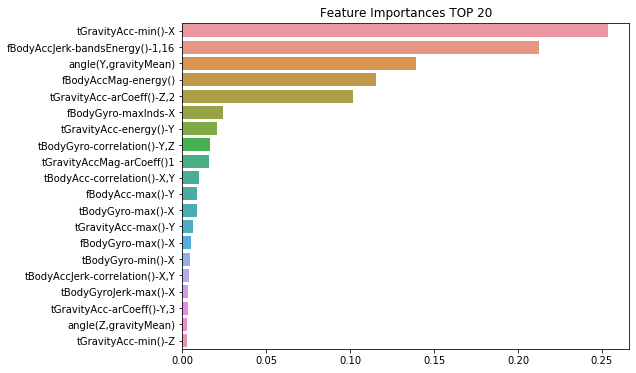

In [21]:
plt.figure(figsize=(8, 6))
plt.title('Feature Importances TOP 20')
sns.barplot(ftr_top20, ftr_top20.index)
plt.show()